In [1]:
import numpy as np
import pylab as pl
from pykalman import UnscentedKalmanFilter
import cv2
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pathlib import Path
import os
from utils_kalman import *

# 6 25

In [18]:
video_file = 'test_6_25/video905.h264'
ang1 = rotate_from_video(video_file)
dis, ang2 = rotate_and_translation_from_video(video_file)
print(ang1, ang2, dis)

3.720302975177765 -0.8958076232138648 21.049963248901896


In [26]:
def points_from_dist_angle(dist, angle):
    num = len(dist)
    points = np.zeros((num+1,2))
    ang = 0
    for i in range(num):
        ang = ang + angle[i]
        points[i+1,0] = points[i,0] - dist[i]*np.sin(ang*np.pi/180)
        points[i+1,1] = points[i,1] + dist[i]*np.cos(ang*np.pi/180)
    return points

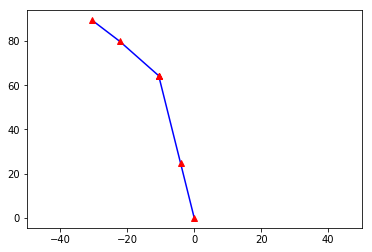

In [28]:
dist = []
angle = []
for i in range(0,6):
    video_file = 'test_6_25/video80'+str(i)+'.h264'
    dis = 0
    if i == 2 or i == 3 :
        ang = rotate_from_video(video_file)
    else:
        dis, ang = rotate_and_translation_from_video(video_file)
    dist.append(dis)
    angle.append(ang)
points = points_from_dist_angle(dist, angle)
pl.figure()
pl.plot(points[:,0] ,points[:,1], color='b')
pl.plot(points[:,0] ,points[:,1], 'r^')
pl.xlim((-50, 50))
pl.show()

In [19]:
def get_matrix_from_video(videofile):
    ang1 = rotate_from_video(video_file)
    dis, ang2 = rotate_and_translation_from_video(video_file)
    if ang2 < 20:
        dis = 0
        ang = ang1
    else:
        ang = ang2
    r = np.array([ang,0,0])
    t = np.array([0,dis*np.sin(ang*np.pi/180),dis*np.cos(ang*np.pi/180)])
    return trans_matrix(r,t)

# Kalman Filter

## example

In [4]:
def transition_function(state, noise):
    a = state[0] * np.sin(state[1]) + noise[0]
    b = state[1] + noise[1]
    return np.array([a, b])

def observation_function(state, noise):
    C = np.array([[-1, 0.5], [0.2, 0.1]])
    return np.dot(C, state) + noise

def additive_transition_function(state):
    return transition_function(state, np.array([0, 0]))

def additive_observation_function(state):
    return observation_function(state, np.array([0, 0]))

transition_covariance = np.eye(2)
random_state = np.random.RandomState(0)
observation_covariance = np.eye(2) + random_state.randn(2, 2) * 0.1
initial_state_mean = [0, 0]
initial_state_covariance = [[1, 0.1], [ 0.1, 1]]

# sample from model
ukf = UnscentedKalmanFilter(
    transition_function, observation_function,
    transition_covariance, observation_covariance,
    initial_state_mean, initial_state_covariance,
    random_state=random_state
)

states, observations = ukf.sample(50, initial_state_mean)

# estimate state with filtering
ukf_state = ukf.filter(observations)
ukf_state_estimates = ukf_state[0]

E:\program\Anaconda3\envs\tensorflow_gpu\lib\site-packages\pykalman-0.9.5-py3.5.egg\pykalman\unscented.py:867: RuntimeWarning: covariance is not positive-semidefinite.
  observation_covariance.newbyteorder('=')


In [9]:
ukf_state[1][0]

array([[0.59065144, 0.24532614],
       [0.24532614, 0.91606503]])

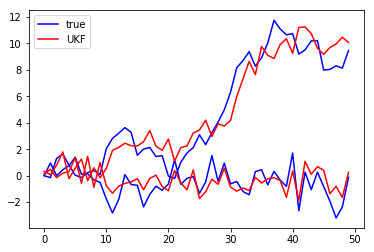

In [5]:
# draw estimates
pl.figure()
lines_true = pl.plot(states, color='b')
lines_ukf = pl.plot(ukf_state_estimates, color='r', ls='-')
pl.legend((lines_true[0], lines_ukf[0]),
          ('true', 'UKF'),
          loc='upper left'
)
pl.show()

### state
the state is { x , y , theta, vx, vy, vtheta, {xi, yi}(for n feature points) }.

the observation is {distance, angle} of the featrue points from the robot point of view.

so the state is a (6+2n) array.

In [2]:
video_file = '4/video4.h264'
dep = np.load('4/dep4.npy')
dep0 = cv2.resize(dep[0,:,:,0], (video_width ,video_height))
filtered_state_estimates, smoothed_state_estimates = kalman_filter(video_file, dep0, 0.33)

feature points shape from optical flow is  (19, 5, 1, 2)
new points is  (19, 5, 1, 2)
[[630.65693431   0.         240.        ]
 [  0.         627.79291553 320.        ]
 [  0.           0.           1.        ]]
initilization shape is  (16,)
observation shape is  (18, 5)


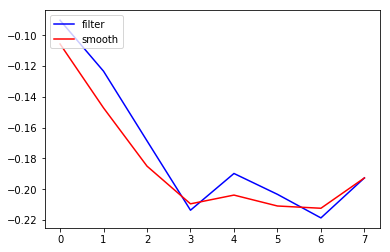

In [4]:
# draw estimates
pl.figure()
lines_true = pl.plot(filtered_state_estimates[:,0] , color='b')
lines_ukf = pl.plot(smoothed_state_estimates[:,0], color='r', ls='-')
pl.legend((lines_true[0], lines_ukf[0]),
          ('filter', 'smooth'),
          loc='upper left'
)
pl.show()

In [46]:
init = points[0].reshape(-1,2)
init

array([[342.,  98.],
       [242., 126.],
       [237., 118.],
       [595., 457.],
       [173., 241.]], dtype=float32)

In [65]:
points, init_image = get_feature_points_from_video(video_file)
i, o = feature_points_to_observation_and_initilization(points, 0, dep0)

feature points shape from optical flow is  (19, 5, 1, 2)
new points is  (19, 5, 1, 2)
[[630.65693431   0.         240.        ]
 [  0.         627.79291553 320.        ]
 [  0.           0.           1.        ]]


In [41]:

observations = np.asarray(o[0:5])
n = observations.shape[1]
print('initilization shape is ', i.shape)
print('observation shape is ', observations.shape)
# initialize the vovariance and mean
transition_covariance = np.eye(2*n+6)
random_state = np.random.RandomState(0)
observation_covariance = np.eye(n) + abs(random_state.randn(n, n) * 0.5)

initial_state_mean = i
covariance_init = random_state.randn(2*n+6, 2*n+6) * 0.1
covariance_init[0:6,0:6] = 0.005
initial_state_covariance =  np.eye(2*n+6) + abs(covariance_init)
# set Unscented kalman filter
kf = UnscentedKalmanFilter(
        transition_function, observation_function,
        transition_covariance, observation_covariance,
        initial_state_mean, initial_state_covariance,
        random_state=random_state
        )
filtered_state_estimates = kf.filter(observations)

initilization shape is  (16,)
observation shape is  (5, 5)


In [43]:
filtered_state_estimates[1].shape

(5, 16, 16)

In [44]:
observations = np.asarray(o[5:-1])
kf = UnscentedKalmanFilter(
        transition_function, observation_function,
        transition_covariance, observation_covariance,
        filtered_state_estimates[0][-1], filtered_state_estimates[1][-1],
        random_state=random_state
        )
filtered_state_estimates = kf.filter(observations)

In [30]:
o[0:5]

array([ 0.06198548, -0.09858284, -0.10740364,  0.38500542, -0.11771525])

In [29]:
filtered_state_estimates[1][-1].shape

(16, 16)

In [66]:
o = np.asarray(o)

In [57]:
x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])

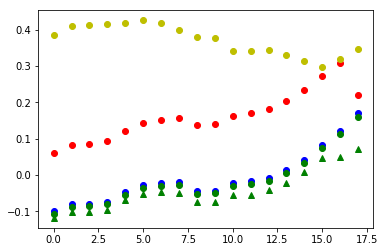

In [70]:
plt.plot(x, o[:,0],'ro',x,o[:,1],'bo',x,o[:,2],'go',x,o[:,3],'yo',x,o[:,4],'g^')

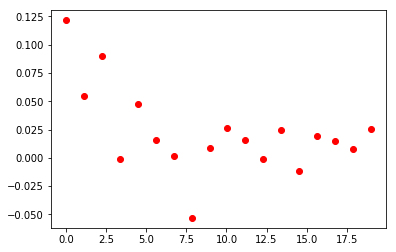

In [46]:
dx = filtered_state_estimates[:,10] - filtered_state_estimates[:,0]
dy = filtered_state_estimates[:,11] - filtered_state_estimates[:,1]
theta = np.arctan2(dx,dy)
plt.plot(x,theta , 'ro' )

In [ ]:
sift = cv2.xfeatures2d.SIFT_create(50)
old_frame = cv2.imread('keys/segs/76ii.jpg')
#old_frame = scipy.ndimage.filters.gaussian_filter(old_frame, 20, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
old_gray = skimage.morphology.closing(old_gray,skimage.morphology.square(5))
kp1, des1 = sift.detectAndCompute(old_gray,None)
p0 = []
for i in range(len(kp1)):
    p0.append(kp1[i].pt)
p0 = np.reshape(np.ravel(p0),(-1,1,2))
p0 = p0.astype(np.float32)
mask = np.zeros_like(old_frame)


In [9]:
np.isnan(np.nan)

True

In [63]:
cap = cv2.VideoCapture('video1.h264')
# params for ShiTomasi corner detection
sift = cv2.xfeatures2d.SIFT_create()
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
# Create some random colors
color = np.random.randint(0,255,(100,3))
# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
kp1, des1 = sift.detectAndCompute(old_gray,None)
p0 = []
for i in range(len(kp1)):
    p0.append(kp1[i].pt)
p0 = np.reshape(np.ravel(p0),(-1,1,2))
p0 = p0.astype(np.float32)
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)
while(1):
    ret,frame = cap.read()
    if ret == False:
        break
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    # Select good points
    if p1 is None:
        break
    good_new = p1[st==1]
    good_old = p0[st==1]
    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
    img = cv2.add(frame,mask)
    cv2.imshow('frame',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)
cv2.destroyAllWindows()
cap.release()

IndexError: index 100 is out of bounds for axis 0 with size 100

In [4]:
cap = cv2.VideoCapture('keys/videos/video804.h264')
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.05,
                       minDistance = 7,
                       blockSize = 7 )
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
# Create some random colors
color = np.random.randint(0,255,(100,3))
# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

while(1):
    ret,frame = cap.read()
    if ret == False:
        break
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    if p1 is None:
        break
    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]
    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
    img = cv2.add(frame,mask)
    cv2.imshow('frame',img)
    k = cv2.waitKey(100) & 0xff
    if k == 27:
        break
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)
cv2.destroyAllWindows()
cap.release()

In [13]:
video_file = '5/video6.h264'
r, angle = rotate_and_translation_from_video(video_file)
print(r, angle)

35.0212166560912 -4.277379944991125


In [12]:
video_file = '5/video6.h264'
dis = rotate_from_video(video_file)
print(dis)

[26.215218   6.1802573  6.052357   9.978608  11.719773  -1.1022519
 11.135259   9.004427   2.9519804  8.052623  17.047836   6.8484826
 -1.9448535  3.6034677 10.392591   9.088927   4.4060216  6.965023 ]


In [42]:
dis

array([ 14.562871  ,   6.587079  ,  -2.2408583 ,   0.44688687,
        13.97021   ,   7.6374655 ,  -0.0252327 ,  -0.91142845,
       -13.2944765 ,   0.67467594,   6.3951964 ,  -2.2431977 ,
         7.100998  ,  12.622195  ,   6.2585025 ,   3.1439335 ,
        22.093777  ,   4.847871  ], dtype=float32)

### animation images

In [8]:
def from_KF_result_to_points(estimate):
    num = int((len(estimate) - 6)/2)
    x = np.zeros(num)
    y = np.zeros(num)
    for i in range(num):
        x[i] = estimate[6+2*i]
        y[i] = estimate[6+2*i+1]
    return x,y

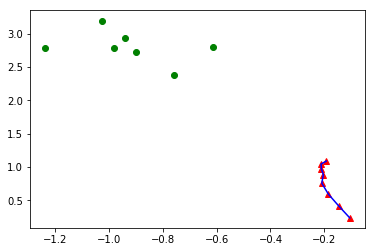

In [13]:
num_obs = filtered_state_estimates.shape[0]
ims = []
fig = plt.figure()
for i in range(num_obs):
    x1,y1 = from_KF_result_to_points(filtered_state_estimates[i])
    im = plt.plot( x1,y1, 'go',
        smoothed_state_estimates[0:i+1,0],-smoothed_state_estimates[0:i+1,1], 'r^',
        smoothed_state_estimates[0:i+1,0],-smoothed_state_estimates[0:i+1,1], 'b')
    ims.append(im)
    
ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True,
                                repeat_delay=1000)

ani.save('dynamic_images.mp4')
plt.show()

In [43]:
def make_animation( smoothed_state_estimates1, smoothed_state_estimates2):
    ims = []
    num_obs1 = smoothed_state_estimates1.shape[0]
    for i in range(num_obs1):
        x1,y1 = from_KF_result_to_points(smoothed_state_estimates1[i])
        im = plt.plot( x1,y1, 'go',
            smoothed_state_estimates1[0:i+1,0],-smoothed_state_estimates1[0:i+1,1]/4, 'r^',
            smoothed_state_estimates1[0:i+1,0],-smoothed_state_estimates1[0:i+1,1]/4, 'b')
        ims.append(im)
    ori = [smoothed_state_estimates1[num_obs1-1,0],-smoothed_state_estimates1[num_obs1-1,1]/4]
    
    num_obs2 = smoothed_state_estimates2.shape[0]
    for i in range(num_obs2):
        x0,y0 = from_KF_result_to_points(smoothed_state_estimates1[num_obs1-1])
        x1,y1 = from_KF_result_to_points(smoothed_state_estimates2[i])
        im = plt.plot( x1+ori[0],y1+ori[1], 'bo',x0,y0, 'go',
            smoothed_state_estimates2[0:i+1,0]+ori[0],-smoothed_state_estimates2[0:i+1,1]/4+ori[1], 'y^',
            smoothed_state_estimates2[0:i+1,0]+ori[0],-smoothed_state_estimates2[0:i+1,1]/4+ori[1], 'b',
            smoothed_state_estimates1[0:num_obs1,0],-smoothed_state_estimates1[0:num_obs1,1]/4, 'r^',
            smoothed_state_estimates1[0:num_obs1,0],-smoothed_state_estimates1[0:num_obs1,1]/4, 'b')
        ims.append(im)
    
    return ims

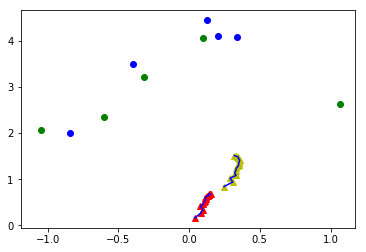

In [44]:
fig = plt.figure()
smoothed_state_estimates1 = np.load('4/smoothed_state_estimates3.npy')
smoothed_state_estimates2 = np.load('4/smoothed_state_estimates4.npy')
ims = make_animation( smoothed_state_estimates1, smoothed_state_estimates2)
ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True,
                                repeat_delay=1000)

ani.save('dynamic_images.mp4')
plt.show()

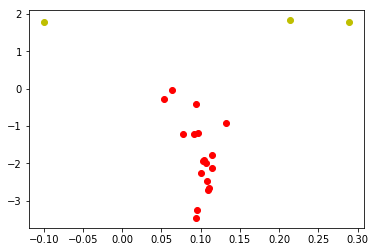

In [42]:
plt.plot(filtered_state_estimates[:,0], filtered_state_estimates[:,1], 'ro')
#plt.plot(from_KF_result_to_points(filtered_state_estimates[17]), 'go')
x1,y1 = from_KF_result_to_points(filtered_state_estimates[0])
plt.plot(x1,y1, 'yo')
#plt.axis([-5, 5, -5, 5])
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()

def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(60):
    x += np.pi / 15.
    y += np.pi / 20.
    im = plt.imshow(f(x, y), animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

#ani.save('dynamic_images.mp4')

plt.show()

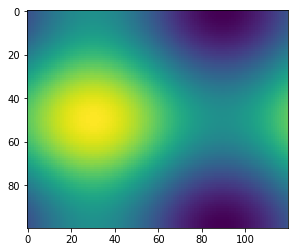

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(60):
    x += np.pi / 15.
    y += np.pi / 20.
    im = plt.imshow(f(x, y), animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

#ani.save('dynamic_images.mp4')

plt.show()

In [151]:
def trans_matrix(r,t):
    # T (ki to t), rotate and transport matrix
    r = r.ravel()
    t = t.ravel()
    (a,b,c) = (r[0], r[1], r[2])
    (x,y,z) = (t[0], t[1], t[2])
    Rz = np.matrix([[1,0,0],
          [0, np.cos(a), -np.sin(a)],
         [0, np.sin(a), np.cos(a)]])
    Ry = np.matrix([[np.cos(b), 0 , np.sin(b)],
          [0 , 1, 0],
          [-np.sin(b), 0 , np.cos(b)]])
    Rx = np.matrix([[np.cos(c), -np.sin(c), 0],
         [np.sin(c), np.cos(c), 0],
         [0,0,1]])
    R = np.dot(Rz,np.dot(Ry,Rx))
    T = np.concatenate((R, np.matrix([[x],[y],[z]])), axis=1)

    return T

In [153]:
state = smoothed_state_estimates[-1,0:3]
t = np.array([0,state[0], state[1]])
r = np.array([state[2],0,0])
trans_matrix(r,t)

matrix([[  1.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.98528125,   0.17094107,   0.42480124],
        [  0.        ,  -0.17094107,   0.98528125, -23.90627193]])

In [ ]:
trans_matrix(r,t)

## use optical flow as observation

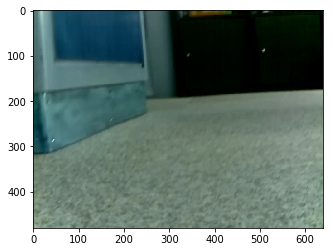

In [27]:
video_file = '4/video4.h264'
cap = cv2.VideoCapture(video_file)
ret,frame = cap.read()
plt.imshow(frame)

In [18]:
def calu_dep(imagefile,depfile):
    ckptfile = 'F:/pfe/cnn_slam/FCRN-DepthPrediction-master/ckpt/NYU_FCRN.ckpt'
    my_file = Path(depfile)
    if not my_file.is_file():
        os.system("python predict.py "+ ckptfile + " " +imagefile+" "+depfile )
    return 0

In [19]:
def calucate_dep(init_image):
    cv2.imwrite('temp.jpg',init_image)
    a = calu_dep('temp.jpg','dep.npy')
    return np.load('dep.npy')

In [28]:
dep = calucate_dep(frame)